# Basic signal detection

Notebook intended to play around with detecting signals in white Gaussian noise.

Detecting a signal embedded in noise is a very common and universal task. For example, one may wish to detect whether a planet is present by the attenuation of incoming light from a star. However, all measurements have inevitable noise, be it process noise or measurement noise. Discerning what is signal from what is noise then becomes extremely important.

In this notebook I apply basic statistical signal processing methods to create powerful detection tools. First, I start with the simplest case, and step by step make the problem more complicated. In the end I run a Monte-Carlo search to detect a signal of unknown parameters embedded in noise.

1. Detection of a signal in white Gaussian noise
    1. Signal with known parameters
    1. Signal with unknown amplitude
    1. Signal with unknown amplitude and timing
    1. Signal with unknown amplitude, timing and width

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as ss

# Define units
s = 1
Hz = 1 / s

# 1. Detection of a signal in white Gaussian noise

When we know how a signal looks, the task is easiest. This can happen, for example, in a radar system, where the shape of the pulse to be received is known beforehand. 

First we define our signal. In this case I use a simple boxcar, but any other template will do (like a Gaussian pulse, a heart beat, a gravitational wave merger, etc.). A  boxcar has 3 parameters: its position/time of arrival $t_0$, its width $w$ and its strength $A$. I define a normalized boxcar, and keep the amplitude as a coefficient to the template. 

$$
h(t) = \begin{cases} \frac{1}{w},\ t \in [t_0 - w/2, t_0 + w/2] \\ 0, \ \text{elswehere}\end{cases},
$$

where normalization ensures $||h(t)||^2 = \sqrt{\sum_t |h(t)|^2} = 1$. For now I will assume $A=1$.

In [2]:
def boxcar_pulse(t, center, width):
    """ Template function for a boxcar pulse, created on time grid x sampled at fs. """
    signal = np.where(
        (t > center - width/2) & (t < center + width/2),
        1,
        0,
    )
    return signal /  np.linalg.norm(signal)

## 1.1 Signal with known parameters

Now that we have designed a template that we want to find, we can set up the simplest version of the problem. We want to know if a signal contains the pulse defined above. The signal contains white gaussian noise (WGN). Defining our statistical model we have,

$$
\begin{align*}
\mathcal{H}_0\ &:\ d(t) = n(t), \\
\mathcal{H}_1\ &:\ d(t) = h(t) + n(t), \\
n(t) &\sim \mathcal{N}(0, \sigma^2).
\end{align*}
$$

Under the null hypothesis, the data contains no signal. The alternative hypothesis states that the signal is present in the data.

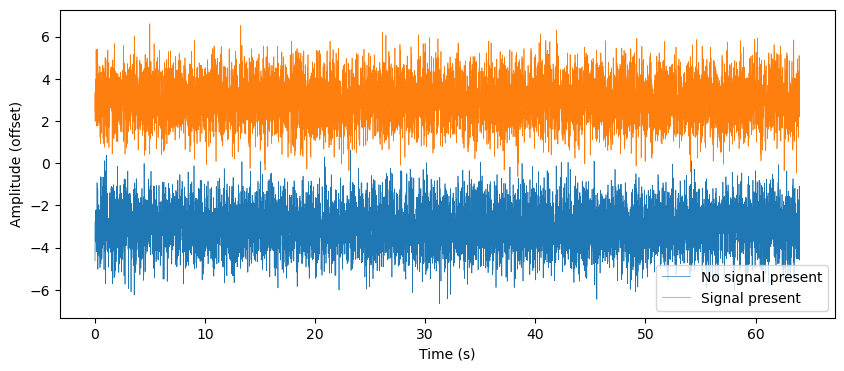

In [3]:
# Data parameters
len_t = 64 * s
fs = 128 * Hz
t_grid = np.arange(0, len_t, 1/fs)

# Template parameters
center = 32 * s
width = 3 * s
h = boxcar_pulse(t_grid, center, width)

# Noise parameters
sigma = 1 

# Simulation parameters
N_repetitions = 10000


d_no_signal = np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_signal = h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))

plt.figure(figsize=(10, 4))
plt.plot(t_grid, d_no_signal[0] - 3, label='No signal present', lw=0.5)
plt.plot(t_grid, d_signal[0] + 3, label='Signal present', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset)')
plt.legend()
plt.show()

It becomes aparent that we cannot know if there is a signal present by the naked eye. For this we need the power of statistics. 

Applying the Neyman-Pearson lemma we can derive the optimal test-statistic by use of the likelihood ratio test.

Under both hypotheses we have the pdfs,

$$
\begin{align*}
p(\vec{d}|\mathcal{H}_0) &= \prod_t \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\frac{|d(t)|^2}{\sigma^2}} = \frac{1}{\sqrt{(2\pi\sigma^2)^N}}e^{-\frac{1}{2}\sum_t \frac{|d(t)|^2}{\sigma^2}}, \\
p(\vec{d}|\mathcal{H}_1) &= \prod_t \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\frac{|d(t) - h(t)|^2}{\sigma^2}} = \frac{1}{\sqrt{(2\pi\sigma^2)^N}}e^{-\frac{1}{2}\sum_t \frac{|d(t) - h(t)|^2}{\sigma^2}}.
\end{align*}
$$

We now take the likelihood ratio test to obtain the optimal test statistic, as according to the Neyman-Pearson lemma, 
$$
\mathcal{T} = \frac{p(\vec{d}|\mathcal{H}_1)}{p(\vec{d}|\mathcal{H}_0)} \gtrless \eta
$$

is the test statistic maximizing the power at a given threshold $\eta$, set by the type I error. In other words, there are no other statistics which are more discriminating than the one obtained through the LRT. 

Applying monotone transformations one can greatly simplify this test statistic.

$$
\begin{align*}
\mathcal{T} \cong -\sum_t \frac{|d(t) - h(t)|^2}{\sigma^2} + \sum_t \frac{|d(t)|^2}{\sigma^2} = \sum_t \frac{ 2 d(t)h(t) - |h(t)|^2}{\sigma^2}.
\end{align*}
$$

We further simplify by removing elements independent of the data (constants) to arrive at the famous matched filter,

$$
\mathcal{T} \cong \sum_t \frac{d(t)h(t)}{\sigma^2} = \frac{\vec{d}^\intercal\vec{h}}{\sigma^2}.
$$

As stated earlier, this is the statistically most powerful test to discern the signal within the noise. To understand how the statistic distributes, let's calculate expectation values and variances.

$$
\begin{align*}
\mathbb{E}[\mathcal{T}|\mathcal{H}_0] &= \mathbb{E}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2}\right] = \frac{\sum_t h(t)\mathbb{E}[d(t)]}{\sigma^2} = 0, \\
\mathbb{E}[\mathcal{T}|\mathcal{H}_1] &= \mathbb{E}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2}\right] = \frac{\sum_t h(t)\mathbb{E}[d(t)]}{\sigma^2} = \frac{\sum_t |h(t)|^2}{\sigma^2} = \frac{1}{\sigma^2} \\
\end{align*}
$$

The template normalization allows the expression to be simplified. Now we calculate the variance, which is independent of the hypothesis.

$$
\mathbb{V}[\mathcal{T}] = \mathbb{V}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2} \right] = \frac{\sum_t|h(t)|^2\mathbb{V}[d(t)]}{\sigma^4} = \frac{\sum_t |h(t)|^2}{\sigma^2} = \frac{1}{\sigma^2}.
$$

Now we know how the test statistic distributes, as it is a linear combination of other gaussians,

$$
\mathcal{T}|\mathcal{H}_0 \sim \mathcal{N}(0, 1/\sigma^2), \quad \mathcal{T}|\mathcal{H}_1 \sim \mathcal{N}(1/\sigma^2, 1/\sigma^2).
$$

To put this to the test, we generate many realizations of the data, some with a pulse in them, some without. Then we calculate the derived test statistic and plot its distribution.

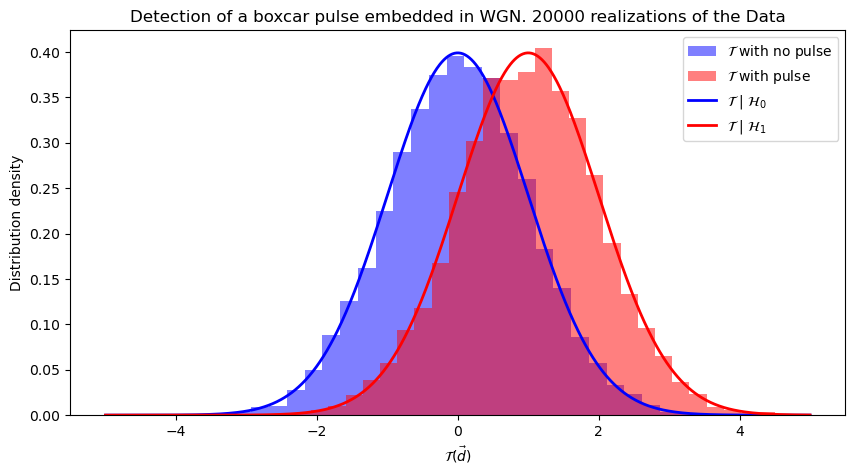

In [4]:
T_no_pulse = np.sum(d_no_signal * h / sigma**2, axis=1)
T_pulse = np.sum(d_signal * h / sigma**2, axis=1)

x_grid = np.linspace(-5, 5, 1000)
H0_dist = sps.norm.pdf(x_grid, 0, 1/sigma)
H1_dist = sps.norm.pdf(x_grid, 1/sigma**2, 1/sigma)

plt.figure(figsize=(10, 5))
plt.hist(T_no_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with no pulse', color='blue', density=True)
plt.hist(T_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with pulse', color='red', density=True)
plt.plot(x_grid, H0_dist, label='$\mathcal{T}$ | $\mathcal{H}_0$', color='blue', lw=2)
plt.plot(x_grid, H1_dist, label='$\mathcal{T}$ | $\mathcal{H}_1$', color='red', lw=2)
plt.legend()
plt.title(f"Detection of a boxcar pulse embedded in WGN. {2*N_repetitions} realizations of the Data")
plt.ylabel("Distribution density")
plt.xlabel(r'$\mathcal{T}(\vec{d})$')
plt.show()

Despite being completely invisible by the naked eye, the optimal test statistic derived can discern between noise containing the signal, and empty noise.

Before setting the threshold $\eta$ to make a decision, we can visualize the power of this statistic by plotting the receiver operating characteristic (ROC) curve. This plot shows type I ($\beta_1$) vs type II ($\beta_0$) errors as the threshold $\eta$ is varied, essentially portraying how "separated" the above gaussians are. Defining both types of error,

$$
\begin{align*}
\beta_1 &= P(\mathcal{T}>\eta|\mathcal{H}_0) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathcal{T}}}} \int_\eta^\infty e^{-\frac{x^2}{2\sigma^2_{\mathcal{T}}}} dx = \frac{1}{2}\left(1 - \text{erf}\left(\frac{\eta}{\sqrt{2}\sigma_\mathcal{T}}\right) \right), \\
\beta_0 &= P(\mathcal{T}<\eta|\mathcal{H}_1) =  \frac{1}{\sqrt{2\pi\sigma^2_{\mathcal{T}}}} \int_{-\infty}^\eta e^{-\frac{(x-\mu_{\mathcal{T}})^2}{2\sigma^2_{\mathcal{T}}}} dx = \frac{1}{2}\left(1 + \text{erf}\left(\frac{\eta - \mu_\mathcal{T}}{\sqrt{2}\sigma_\mathcal{T}}\right) \right).

\end{align*}
$$

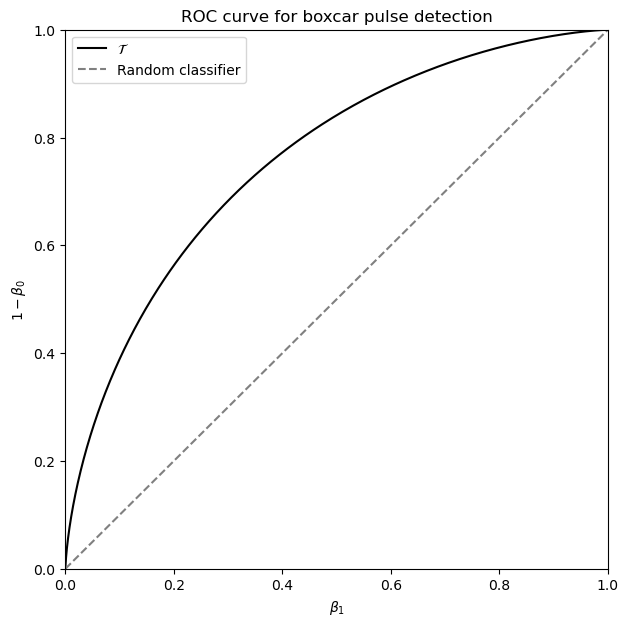

In [5]:
def calc_beta_1(eta_grid, sigma_T):
    return 1/2 * (1 - ss.erf(eta_grid / (2**0.5 * sigma_T)) )

def calc_beta_0(eta_grid, sigma_T, mu_T):
    return 1/2 * (1 + ss.erf((eta_grid - mu_T) / (2**0.5 * sigma_T)) )

eta_grid = np.linspace(-4, 4, 1000)
betas_0 = calc_beta_1(eta_grid, 1/sigma**2)
betas_1 = calc_beta_0(eta_grid, 1/sigma**2, 1/sigma**2)

plt.figure(figsize=(7, 7))
plt.plot(betas_1, 1 - betas_0, label='$\mathcal{T}$', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$1 -\beta_0$')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC curve for boxcar pulse detection')
plt.show()

Now we wish to make a decision. Given an observation, is the signal present? For this we have developed the optimal test statistic, and now we need to make some decisions to fix the threshold $\eta$. Assume that for this specific application, we cannot afford a false alarm rate ($\beta_1$) above 5%. This will fix $\eta$. Rearanging the expresion for $\beta_1$,
$$
\eta = \sigma_\mathcal{T}\sqrt{2}\text{erf}^{-1}\left(1-2\beta_1\right)
$$



In [6]:
def calc_eta(sigma_T, beta_1):
    """ Compute the threshold eta for a given beta_1 and sigma_T. """
    return 2**0.5 * sigma_T * ss.erfinv(1 - 2 * beta_1)

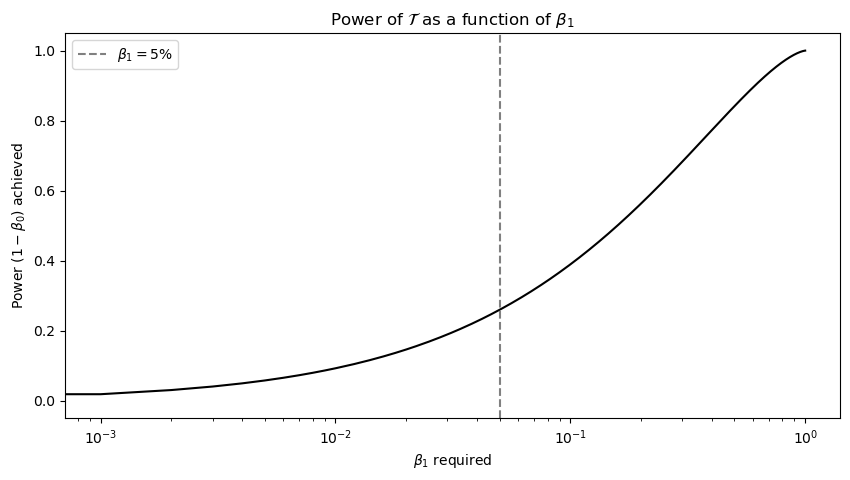

In [7]:
beta_1_grid = np.linspace(0, 1, 1000)
eta = calc_eta(1/sigma, beta_1_grid)
beta_0 = calc_beta_0(eta, 1/sigma**2, 1/sigma)

plt.figure(figsize=(10, 5))
plt.plot(beta_1_grid, 1-beta_0, color='black')
plt.xlabel(r'$\beta_1$ required')
plt.ylabel(r'Power ($1 - \beta_0$) achieved')
plt.axvline(0.05, linestyle='--', color='gray', label=r'$\beta_1 = 5\%$')
plt.title(r"Power of $\mathcal{T}$ as a function of $\beta_1$")
plt.xscale('log')
plt.legend()
plt.show()

In [8]:
power = 1 - calc_beta_0(calc_eta(1/sigma, 0.05), 1/sigma, 1/sigma**2)
print(f"Power of the test at beta_1 = 0.05: {power:.4f}")

Power of the test at beta_1 = 0.05: 0.2595


This graph shows the power of our test. At a fixed false alarm rate of $\beta_1 = 5\%$, the derived test statistic achieves a power of $1 - \beta_0 = 26\%$. No other test out there will achieve a higher power than this.

## 1.2 Signal with an unkown amplitude

The first generalization we make is removing the constraint of $A=1$. Now we have one unknown parameter in our data, and as such the hypothesis becomes a composite hypothesis. Since the Neyman-Pearson lemma only works for simple hypothesis, we will have to circumvent this. The statistical model is,

$$
\begin{align*}
\mathcal{H}_0\ &:\ d(t) = n(t), \\
\mathcal{H}_1(A)\ &:\ d(t) = Ah(t) + n(t), \\
n(t) &\sim \mathcal{N}(0, \sigma^2).
\end{align*}
$$

In this case, we can assume that we know $A$, and derive the matched filter test statistic just as done above. 

$$
\mathcal{T} = \sum_t \frac{A h(t) d(t)}{\sigma^2} \gtrless \eta
$$

Once again, applying a monotone transform,

$$
\mathcal{T} = \sum_t \frac{h(t) d(t)}{\sigma^2} \gtrless \eta(A)
$$

Here we see that, independent of $A$ (this will only change where the threshold sits), the most powerful test is still the same. This phenomenon is coined the uniquely most powerful test (UMP). It is a result of the more general Karlin-Rubin theorem.

This test will distribute as
$$
\mathcal{T}|\mathcal{H}_0 \sim \mathcal{N}(0, 1/\sigma^2), \quad \mathcal{T}|\mathcal{H}_1 \sim \mathcal{N}(A/\sigma^2, 1/\sigma^2).
$$

Let's now put it to the test, in a similar fashion as done above. Intuitively, we expect the classification to become better as the amplitude of the signal grows (we might even get to detect it by eye).


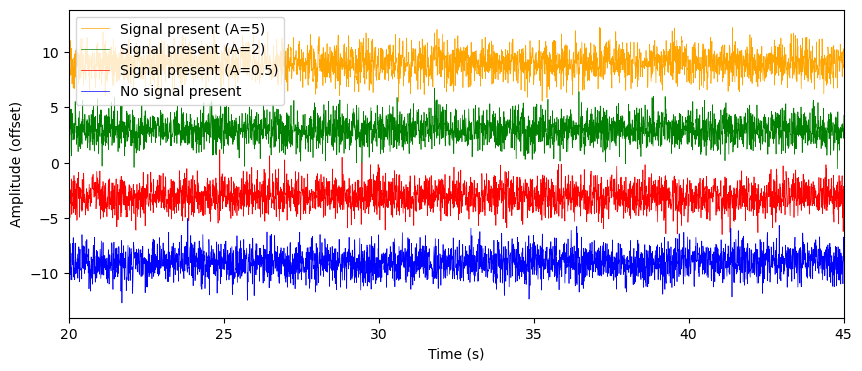

In [ ]:
# Template parameters
center = 32 * s
width = 0.5 * s
h = boxcar_pulse(t_grid, center, width)

# Noise parameters
sigma = 1

# Simulation parameters
N_repetitions = 10000


d_no_signal = np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_05 = 0.5 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_2 = 2 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_5 = 5 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))

plt.figure(figsize=(10, 4))
plt.plot(t_grid, d_5[0] + 9, label='Signal present (A=5)', lw=0.5, c='orange')
plt.plot(t_grid, d_2[0] + 3, label='Signal present (A=2)', lw=0.5, c='green')
plt.plot(t_grid, d_05[0] - 3, label='Signal present (A=0.5)', lw=0.5, c='red')
plt.plot(t_grid, d_no_signal[0] - 9, label='No signal present', lw=0.5, c='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset)')
plt.xlim(20, 45)
plt.legend(loc='upper left')
plt.show()

The pulse starts becoming visible by the naked eye. But our statistic can do better.

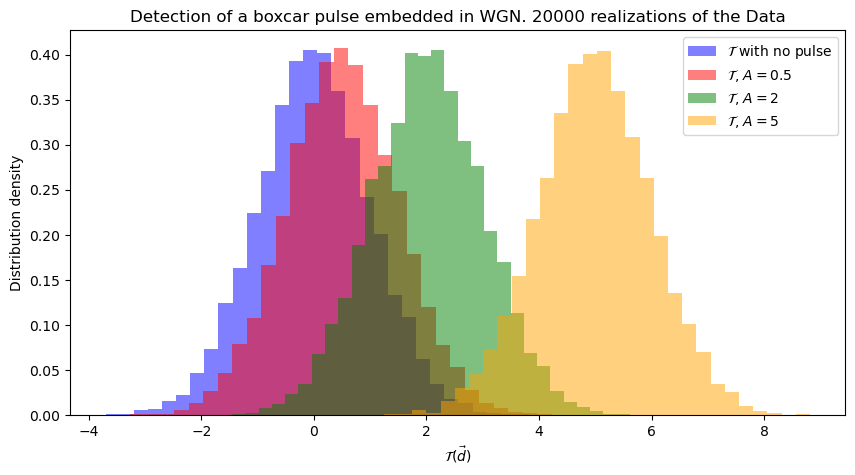

In [15]:
T_no_pulse = np.sum(d_no_signal * h / sigma**2, axis=1)
T_05 = np.sum(d_05 * h / sigma**2, axis=1)
T_2 = np.sum(d_2 * h / sigma**2, axis=1)
T_5 = np.sum(d_5 * h / sigma**2, axis=1)


plt.figure(figsize=(10, 5))
plt.hist(T_no_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with no pulse', color='blue', density=True)
plt.hist(T_05, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=0.5$', color='red', density=True)
plt.hist(T_2, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=2$', color='green', density=True)
plt.hist(T_5, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=5$', color='orange', density=True)
plt.legend()
plt.title(f"Detection of a boxcar pulse embedded in WGN. {2*N_repetitions} realizations of the Data")
plt.ylabel("Distribution density")
plt.xlabel(r'$\mathcal{T}(\vec{d})$')
plt.show()

As done above, we can plot the ROC to see which signal will be detected better. We know how the statistic distributes as a function of $A$, so we can calculate the type I and type II errors.

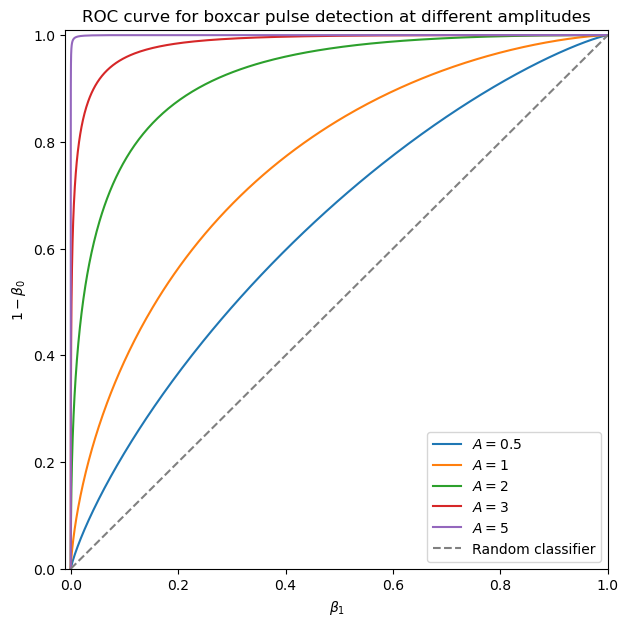

In [16]:
eta_grid = np.linspace(-5, 8, 1000)
betas_1 = calc_beta_1(eta_grid, 1/sigma)

plt.figure(figsize=(7, 7))
for A in [0.5, 1, 2, 3, 5]:
    betas_0 = calc_beta_0(eta_grid, 1/sigma, A/sigma**2)
    plt.plot(betas_1, 1 - betas_0, label=f'$A={A}$')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$1-\beta_0$")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
plt.legend()
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.title('ROC curve for boxcar pulse detection at different amplitudes')
plt.show()

From the ROC we can see that for $A=5$, the statistic is almost perfect, hugging the top left corner nearly maximally.

Now we can ask ourself: what is the minimum amplitude pulse that we can detect 50% of the time? That is, for what $A$ is the power of our test $1-\beta_0 = 0.5$, while keeping our $\beta_1$ at 5%?

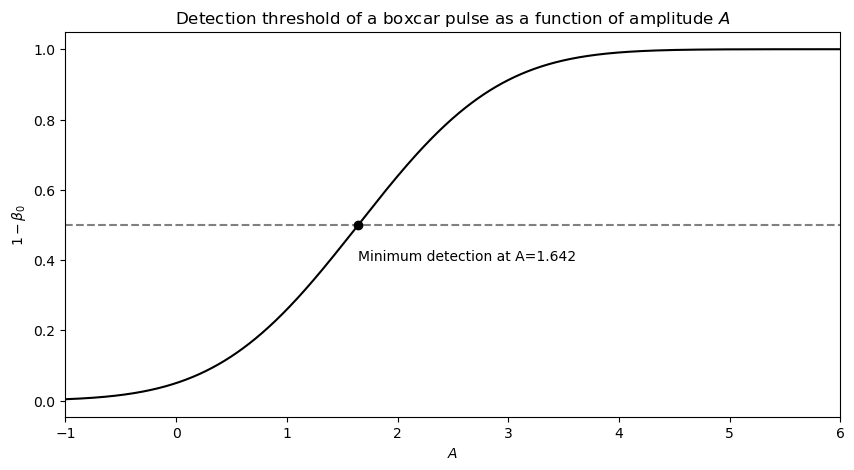

In [17]:
eta = calc_eta(1/sigma, 0.05)

A_grid = np.linspace(-1, 6, 1000)
beta_0 = calc_beta_0(eta, 1/sigma, A_grid / sigma**2)
A_limit = np.argwhere(np.diff(np.sign(1 - beta_0 - 0.5))).flatten()[0]


plt.figure(figsize=(10, 5))
plt.plot(A_grid, 1 - beta_0, color='black')
plt.axhline(0.5, ls='--', c='gray')
plt.plot(A_grid[A_limit], 0.5, 'ko')
plt.text(A_grid[A_limit], 0.4, f"Minimum detection at A={float(A_grid[A_limit]):.3f}")
plt.xlabel(r'$A$')
plt.ylabel(r'$1 - \beta_0$')
plt.title(r"Detection threshold of a boxcar pulse as a function of amplitude $A$")
plt.xlim(-1, 6)
plt.show()


With this test statistic, we can also derive an estimator for the amplitude of the signal,

$$
\hat{A} = \frac{\mathcal{T}}{\mathbb{V}[\mathcal{T}|\mathcal{H}_0]},
$$

given that

$$
\mathbb{E}[\hat{A}] = \frac{\mathbb{E}[\mathcal{T}]}{\mathbb{V}[\mathcal{T}|\mathcal{H}_0]} = \frac{\sum_t A\frac{|h(t)|^2}{\sigma^2}}{\sum_t \frac{|h(t)|^2}{\sigma^2}} = A.
$$

##  1.3 Signal with unknown amplitude and timing

Now say we also don't know the time of arrival $t_0$ of the pulse. Now there is no easy loophole like the Karlin-Rubin theorem above. Instead we need to try all possible values of $t_0$. This is equivalent to using the convolution,

$$
\mathcal{T}(t_0) = \sum_t \frac{d(t)h(t-t_0)}{\sigma^2} = \frac{(\vec{d}\circledast\overleftarrow{h})(t_0)}{\sigma^2}. \tag{1.3.1}
$$

Whenever we see convolutions, it is convenient (and fast) to work in the Fourier domain. Transforming to the Fourier domain will keep all Gaussian noises as Gaussian, as it is a linear transformation. 

Define the DFT matrix $\mathbf{F}$ to be normalized by $1/\sqrt{N}$, so that it is unitary ($\mathbf{FF}^\dagger = \mathbf{F}^\dagger\mathbf{F}= \mathbf{I}$). Then, denote $\tilde{h} = \mathbf{F}\vec{h}$, or $\vec{h} = \mathbf{F}^{-1}\tilde{h}$. Then we can rewrite the matched filter derived earlier, now in Fourier space,

$$
\mathcal{T} = \frac{\vec{d}^\intercal\vec{h}}{\sigma^2} = \frac{\left( \mathbf{F}^{-1} \tilde{h} \right)^\dagger \left( \mathbf{F}^{-1} \tilde{d} \right)}{\sigma^2} = \frac{\tilde{h}^\dagger (\mathbf{F}\mathbf{F}^\dagger)\tilde{d}}{\sigma^2} = \frac{\tilde{d}^\dagger\tilde{h}}{\sigma^2} = \sum_f \frac{\tilde{h}^*(f)\tilde{d}(f)}{\sigma^2}.
$$

Just to finish the formalization, let's see how our Gaussian noise behaves in Fourier space.

$$
\tilde{n}(f) = \frac{1}{\sqrt{N}} \sum_t n(t)e^{-\frac{2\pi i ft}{N}}.
$$

$$
\mathbb{E}[\tilde{n}(f)] = \frac{1}{\sqrt{N}} \sum_t \mathbb{E}[n(t)]e^{-\frac{2\pi i ft}{N}} = 0 + 0i.
$$

Since the transformation can create correlations in the noise, we calculate its covariance,

$$
\begin{align*}
\mathbb{Cov}[\tilde{n}(f)\tilde{n}(f')] &= \frac{1}{N} \sum_t\sum_{t'} \mathbb{Cov}[n(t)n(t')]e^{\frac{2\pi i ft'}{N}}e^{-\frac{2\pi i f't}{N}}\\
&= \frac{1}{N} \sum_t\sum_{t'} \delta_{t,t'}\sigma^2 e^{\frac{2\pi i ft'}{N}}e^{-\frac{2\pi i f't}{N}}\\
&= \frac{\sigma^2}{N} \sum_t e^{\frac{2\pi it (f - f')}{N}} \\
&= \sigma^2 \delta_{f,f'}.
\end{align*}
$$

Now we can write the test statistic in (1.3.1) for all possible locations of the pulse, by using the convolution theorem,

$$
\mathcal{T}(t_0) = \frac{(\vec{d}\circledast\overleftarrow{h})(t_0)}{\sigma^2} = \frac{\sqrt{N}\mathbf{F}^{-1}(\tilde{d}(f)\cdot\tilde{h}^*(f))(t_0)}{\sigma^2}.
$$


Now we can conduct our first search. We will search for an unknown signal, and estimate its position and amplitude as well. Maximizing the statistic will give us an estimate of its location. Then we use the estimator for $A$ derive above.

In [30]:
def centered_boxcar_pulse(t_grid, width, fs=fs):
    """ Creates a boxcar pulse centered around t=0 with rotational symmetry """
    signal = np.zeros_like(t_grid)
    signal[:(int(width*fs) + 1)//2] = 1.
    signal[len(signal) - int(width*fs)//2:] = 1.
    return signal / np.linalg.norm(signal)

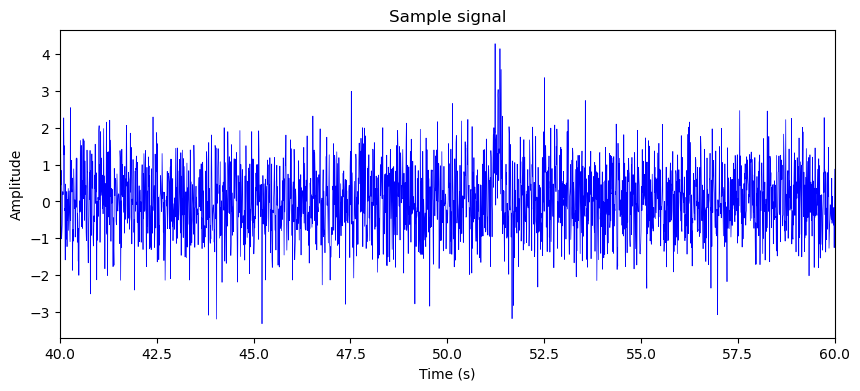

In [32]:
# Parameters to estimate
t0 = 51.3 * s
A = 7.9

# Other template parameeters
width = 0.25 * s
h = boxcar_pulse(t_grid, t0, width)

h_template = centered_boxcar_pulse(t_grid, width) # Create a template centered at 0 for use in the test statistic
f_h_template = np.fft.rfft(h_template, norm='ortho')

# Noise parameters
sigma = 0.9

# Simulation parameters
N_repetitions = 10000

d = A * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
f_d = np.fft.rfft(d, norm='ortho')

plt.figure(figsize=(10, 4))
plt.plot(t_grid, d[0], lw=0.5, c='blue')
plt.title('Sample signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(40, 60)
plt.show()

In [19]:
T = len(t_grid)**0.5 * np.fft.irfft(f_d * np.conjugate(f_h_template), norm='ortho') / sigma**2

# Use test statistic to estimate the signal's parameters
T_max_i = np.argmax(T, axis=-1)
t0_est = t_grid[T_max_i]
A_est = T[np.arange(len(T)), T_max_i] / np.sum(h_template**2 / sigma**2)

Looking at a single realization of the signal

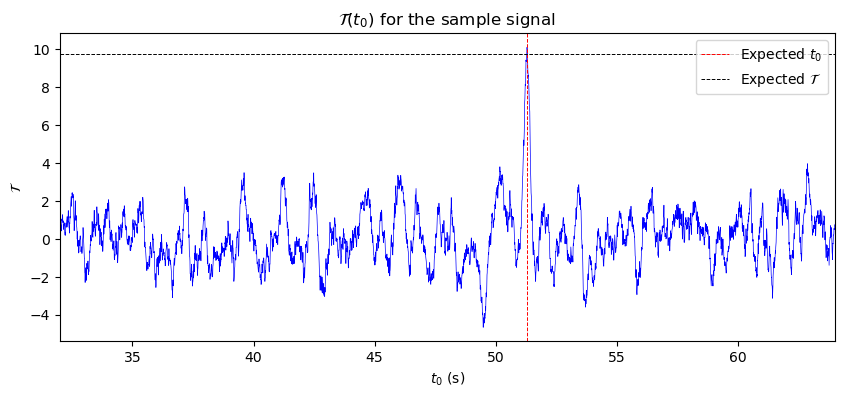

Expected amplitude: 7.9 , Estimated amplitude: 8.19
Expected position: 51.3 s, Estimated position: 51.29s


In [20]:
plt.figure(figsize=(10, 4))
plt.plot(t_grid, T[0], lw=0.5, c='blue')
plt.title('$\mathcal{T}(t_0)$ for the sample signal')
plt.axvline(t0, linestyle='--', color='r', label='Expected $t_0$', lw=0.7)
plt.axhline(A * np.sum(h_template**2 / sigma**2), linestyle='--', color='k', label='Expected $\mathcal{T}$', lw=0.7)
plt.xlabel('$t_0$ (s)')
plt.ylabel('$\mathcal{T}$')
plt.xlim(32, 64)
plt.legend()
plt.show()

print('Expected amplitude:', A, ', Estimated amplitude:', f"{A_est[0]:.2f}")
print('Expected position:', t0, 's, Estimated position:', f"{t0_est[0]:.2f}s")

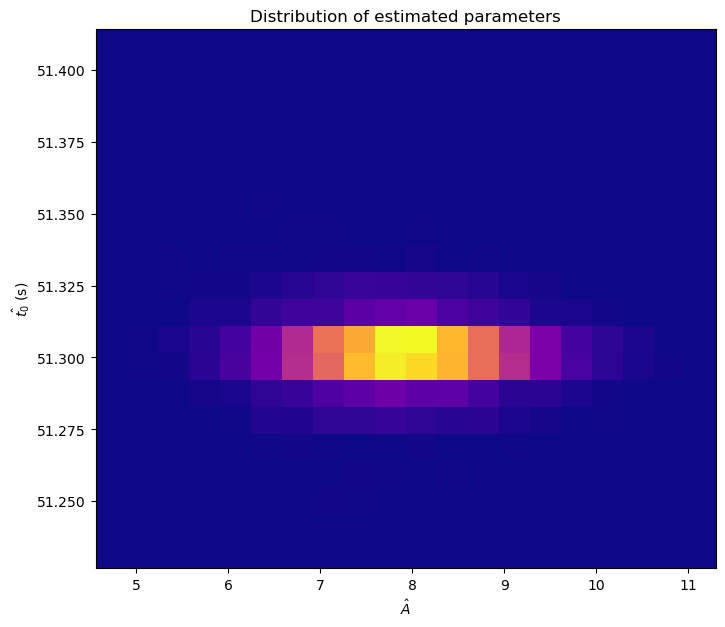

Expected amplitude: 7.9, Mean estimated amplitude: 7.90, Std of estimated amplitude: 0.89
Expected position: 51.3s, Mean estimated position: 51.30s, Std of estimated position: 0.01s


In [21]:
plt.figure(figsize=(8, 7))
plt.hist2d(A_est, t0_est, bins=20, cmap='plasma')
plt.title('Distribution of estimated parameters')
plt.xlabel('$\hat{A}$')
plt.ylabel('$\hat{t_0}$ (s)')
plt.show()

print(f'Expected amplitude: {A}, Mean estimated amplitude: {A_est.mean():.2f}, Std of estimated amplitude: {A_est.std():.2f}')
print(f'Expected position: {t0}s, Mean estimated position: {t0_est.mean():.2f}s, Std of estimated position: {t0_est.std():.2f}s')

## 1.4 Signal with unknown amplitude, timing and width

Now we remove the constraint on the last parameter of the signal: its width. This now makes the test hypothesis composite, as we are not just answering a single yes/no question, but rather trying to reject $\mathcal{H}_0$ against a set of alternative hypotheses, denoted as $\mathcal{H}_\theta$, where $\theta$ denotes the parametrization of the hypothesis.

We can maximize over some parameter space to get a generalized test statistic,
$$
\mathcal{T} = \frac{\sup_{\theta \in \Theta} p(\vec{d}|\mathcal{H}_\theta)}{p(\vec{d}|\mathcal{H}_0)}.
$$

Parameter spaces can quickly become large, making possible searches with Monte-Carlo methods operationally expensive. Therefore we want to remove redundant options to sample the parameter space efficiently.

### 1.4.1 Loss in SNR from using inaccurate templates

Using a template with the wrong width leads to a loss in SNR. Assume the data is $\vec{d} =  A\vec{h}_1 + \vec{n}$. We are trying to detect it with a template $\vec{h}_2$. Our measured statistic is,

$$
\mathcal{T}_m = \frac{\vec{h}_2^\intercal \vec{d}}{\sigma^2} = (\vec{h}_2, \vec{d}),
$$

where I define the noise-weighted inner product $(\cdot, \cdot)$. This statistic has expected value and variances of,

$$
\begin{align*}
\mathbb{E}[(\mathcal{T}_m|\mathcal{H}_1)] &= \frac{\vec{h}_2^\intercal \mathbb{E}[\vec{d}|\mathcal{H}_1]}{\sigma^2} = A(\vec{h}_2, \vec{h}_1), \\
\mathbb{V}[(\mathcal{T}_m|\mathcal{H}_0)] &= (\vec{h}_2, \vec{h}_2) = |\vec{h}_2|.
\end{align*}
$$

Now we can write the optimal and measured SNRs using these expressions,

$$
\begin{align*}
\text{SNR}_o &= A \sqrt{(\vec{h}_1,\vec{h}_1)}. \\
\text{SNR}_m &= \frac{A(\vec{h}_2, \vec{h}_1)}{\sqrt{(\vec{h}_2, \vec{h}_2)}}, \\
\end{align*}
$$

Now we calculate the loss in SNR,

$$
\frac{\text{SNR}_m}{\text{SNR}_o} = \frac{A(\vec{h}_2, \vec{h}_1)}{\sqrt{(\vec{h}_1, \vec{h}_1)(\vec{h}_2, \vec{h}_2)}} = A\cos(\vec{h}_1, \vec{h}_2), \\
$$

where $\cos(\cdot,\cdot)$ is the cosine similarity.

### 1.4.2 Template bank design

Let's say we can allow ourselves to lose up to 1% in $\text{SNR}^2$, and we know that the width of the box is between 0.5s  and 3s. With this, we can create a smart template bank that minimizes the number of templates we have to test.



In [ ]:
def cosine_similarity(h_1, h_2):
    """ Cosine similarity between two given templates """
    return np.dot(h_1, h_2) / (np.linalg.norm(h_1) * np.linalg.norm(h_2))


def create_template_bank(a, b, max_snr_diff, fs=fs):
    """ Create a template bank of widths in [a, b]s keeping the SNR diff at specified maximum """
    dt = 1/fs
    width_bank = [a]
    width_1, width_2 = a, a + dt
    h_1 = centered_boxcar_pulse(t_grid, width_1)
    while width_2 < b:
        h_2 = centered_boxcar_pulse(t_grid, width_2)
        snr_diff = 1 - cosine_similarity(h_1, h_2)
        if snr_diff < max_snr_diff:
            width_2 += dt
        else:
            width_bank.append(width_2)
            width_1 = width_2
            h_1 = h_2
            width_2 += dt
    return width_bank

In [49]:
template_bank = create_template_bank(0.5, 3, 0.01)
print(f"Template bank contains {len(template_bank)} templates.")

Template bank contains 77 templates.
